In [1]:
# KERAS NEURAL NETWORKS
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.models import Model
from keras.utils import multi_gpu_model, to_categorical
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# PROCESS DATA
import pandas as pd
from pandas.plotting import scatter_matrix

# PLOT DATA
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 16,12

import scipy as sp

import numpy as np

import sklearn
from sklearn import model_selection, feature_selection, metrics

# SCIKIT-LEARN LEARNING ALGORITHMS
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process, neural_network

# XGBOOST TREE
from xgboost import XGBClassifier

import re as re

Using TensorFlow backend.


In [2]:
train = pd.read_csv('processed_train.csv')
test = pd.read_csv('processed_test.csv')
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsNotAlone,FamilySize,HasCabin
0,0,3,0,0,0.0,0,0,1,2,0
1,1,1,1,2,3.0,2,4,1,2,1
2,1,3,1,3,1.0,0,3,0,1,0
3,1,1,1,2,3.0,0,4,1,2,1
4,0,3,0,2,1.0,0,0,0,1,0


In [3]:
Y_train = train.Survived.to_numpy().reshape((-1))
#Y_train = 'Survived'
X_train = train.drop('Survived', axis=1).to_numpy().reshape((-1, 9))
#X_train = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'IsNotAlone', 'FamilySize', 'HasCabin']

In [4]:
# Experiment with architectures
Models = [
    #ensemble
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    #gaussian process
    gaussian_process.GaussianProcessClassifier(),
    
    #linear model
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #naive bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #neighbours,
    neighbors.KNeighborsClassifier(),
    neighbors.NearestCentroid(),
    
    #svm
    svm.LinearSVC(),
    svm.NuSVC(),
    svm.SVC(),
    
    #decision tree
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #discriminant analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    #xgboost
    XGBClassifier()
]

In [5]:
# split data for cross validation purposes
cv_split = model_selection.StratifiedShuffleSplit(n_splits=20, test_size = 0.3, train_size = 0.6, random_state=0)
#when cross validating, using this cv_split, the algorithm will run 10 times (n_splits)

# create table to compare machine learning algorithm performance
Model_columns = ['Model Name', 'Model Parameters','Model Train Accuracy Mean', 'Model Test Accuracy Mean', 'Model Test Accuracy 3*STD' ,'Model Time']
Model_compare = pd.DataFrame(columns = Model_columns)
Model_predict = train['Survived'].copy(deep=True) # need to save each model predictions for later

row = 0
for alg in Models:
    
    Model_name = alg.__class__.__name__
    Model_compare.loc[row, 'Model Name'] = Model_name
    Model_compare.loc[row, 'Model Parameters'] = str(alg.get_params())
    
    # score models with cross validation
    cv_results = model_selection.cross_validate(alg, X=X_train, y=Y_train, cv = cv_split, n_jobs=-1, return_train_score=True)
    
    #print(cv_results)
    
    Model_compare.loc[row, 'Model Time'] = cv_results['fit_time'].mean()
    Model_compare.loc[row, 'Model Train Accuracy Mean'] = cv_results['train_score'].mean()
    Model_compare.loc[row, 'Model Test Accuracy Mean'] = cv_results['test_score'].mean()
    
    # if this is a non-bias random sample, then +/-3 standard deviations from the mean should statistically capture 99.7% of the subsets
    Model_compare.loc[row, 'Model Test Accuracy 3*STD'] = cv_results['test_score'].std()*3 # figure out the worst possible score
    
    #save Model predictions for later use in ensembling all high-performing models
    alg.fit(X_train, Y_train)
    Model_predict[Model_name] = alg.predict(X_train)
    
    row = row + 1
    
# print and sort table
Model_compare.sort_values(by = ['Model Test Accuracy Mean'], ascending=False, inplace=True)
Model_compare

/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in

,Model Name,Model Parameters,Model Train Accuracy Mean,Model Test Accuracy Mean,Model Test Accuracy 3*STD,Model Time
17,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.845037,0.827052,0.0565576,0.0058398
16,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.831835,0.825,0.0527309,0.00604097
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.885019,0.821642,0.0488706,1.46018
15,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.828558,0.820709,0.0589656,0.0182395
20,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.826498,0.819776,0.0630354,0.000934291
8,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.824345,0.81903,0.0591803,0.0010401
22,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.872004,0.818097,0.0473436,2.08774
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.880056,0.81791,0.0546791,0.0602375
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': 'warn',...",0.827247,0.815858,0.0465966,0.123748
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.830805,0.811567,0.0480822,0.0545267


0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: object
0      0
1      1
2      1
3      1
4      0
5      0
6      0
7      0
8      1
9      1
10     1
11     1
12     0
13     0
14     0
15     1
16     0
17     1
18     0
19     1
20     0
21     1
22     1
23     1
24     0
25     1
26     0
27     0
28     1
29     0
      ..
861    0
862    1
863    0
864    0
865    1
866    1
867    0
868    0
869    1
870    0
871    1
872    0
873    0
874    1
875    1
876    0
877    0
878    0
879    1
880    1
881    0
882    0
883    0
884    0
885    0
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64


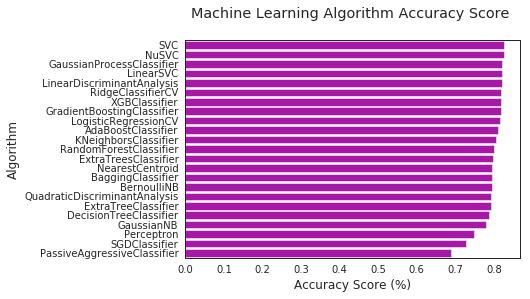

In [7]:
# barplot
sns.barplot(x='Model Test Accuracy Mean', y = 'Model Name', data = Model_compare, color = 'm')

# prettify with pyplot
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

print(Model_predict.head())
print(train['Survived'])

In [ ]:
# perform feature selection
# use decision tree to tune feature selection

dtree = tree.DecisionTreeClassifier(random_state = 0)
dtree_rfe = feature_selection.RFECV(dtree, step=1, scoring = 'accuracy', cv = cv_split)
dtree_rfe.fit(X_train, Y_train)

X_rfe = X_train[:, dtree_rfe.get_support()]
rfe_results = model_selection.cross_validate(dtree, X_rfe, Y_train, cv = cv_split)

print('AFTER DT RFE Training New Shape: ', X_rfe)
print('AFTER DT RFE Training New Columns: ', train.drop('Survived').columns.values[dtree_rfe.get_support()])

print('AFTER DT RFE Training w/bin score mean: {:.2f}'.format(rfe_results['train_score'].mean()*100))
print('AFTER DT RFE Test w/bin score mean: {:.2f}'.format(rfe_results['test_score'].mean()*100))
print('AFTER DT RFE Test w/bin score mean: {:.2f}'.format(rfe_results['test_score'].std()*3*100))

In [ ]:
X = np.array([[1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5]])
Y =[True, False, True, False, False]
X = X[:,Y]
print(X)

From experiment, it seems 3 layers is the best.

In [ ]:
num_models = 15
def buildModel2(num_models):
    
    model = [0] * num_models
    for i in range(num_models):
        inputs = Input(shape=(8,))
        
        X = inputs
        
        X = Dense(32, kernel_regularizer='l2', activation='relu')(X)
        X = Dense(32, kernel_regularizer='l2', activation='relu')(X)
        X = Dense(32, kernel_regularizer='l2', activation='relu')(X)
        
        outputs = Dense(2, activation='sigmoid')(X)
        
        model[i] = multi_gpu_model(Model(inputs=inputs, outputs=outputs), gpus=2)
        model[i].compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
    return model

In [ ]:
model = buildModel2(num_models)
for i in range(num_models):
    print(model[i].summary())
    print('\n')

In [ ]:
#train
history = [0] * num_models
epochs = 100

for i in range(num_models):
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size=0.1)
    history[i] = model[i].fit(x=X_train2, y=Y_train2, batch_size=128, epochs=epochs, verbose=0, callbacks=[reduce_lr], validation_data=(X_val2, Y_val2))
    print("NN {0:d}: Epochs = {1:d} Train Accuracy = {2:.5f} Validation Accuracy = {3:.5f}".format(i+1, epochs, max(history[i].history['acc']), max(history[i].history['val_acc'])))

In [ ]:
# predict
X_test = test.to_numpy().reshape((-1,8))
results = np.zeros((X_test.shape[0], 2))
for i in range(num_models):
    results = results + model[i].predict(X_test)
results = pd.Series(np.argmax(results, axis=1), name='Survived')
passengerid = pd.Series([i for i in range(892,1310)], name='PassengerId')
submission = pd.concat([passengerid, results], axis=1)
print(submission)
submission.to_csv('ENSEMBLE-NN-DATAENGINEERED.csv', index=False)

In [ ]:
import xgboost

In [ ]:
print(xgboost)